In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [3]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [4]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return y - z

lam = 10 ** 8
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

In [5]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [6]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [7]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [8]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

In [9]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

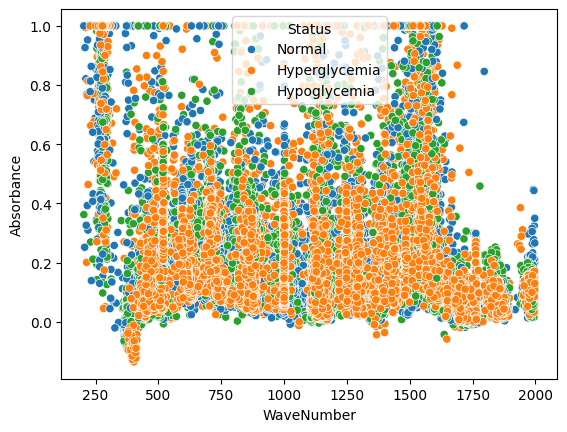

In [10]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue="Status")

In [11]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [12]:
peak_df = peaks_df

In [13]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 0.025

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_20702/1009779721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [14]:
peak_df['GridSlot'].nunique()

1109

In [15]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_20702/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [16]:
peak_df = peak_df.drop(columns=['Seq', 'SurID']) # Dropping irrelevant columns

In [22]:
peak_df = peak_df.drop(columns=['WaveNumber', 'Absorbance', 'Node_ID']) # Dropping irrelevant columns

In [23]:
peak_df

,SpecID,Status,GridSlot
728,201210-1-00,Normal,"(13, 16)"
1025,201210-1-00,Normal,"(18, 10)"
1368,201210-1-00,Normal,"(22, 3)"
1535,201210-1-00,Normal,"(24, 3)"
1818,201210-1-00,Normal,"(28, 6)"
...,...,...,...
8009580,210526-3-49,Hyperglycemia,"(28, 9)"
8009759,210526-3-49,Hyperglycemia,"(31, 10)"
8009935,210526-3-49,Hyperglycemia,"(33, 2)"
8010192,210526-3-49,Hyperglycemia,"(37, 4)"


In [25]:
from itertools import combinations

# Create a DataFrame mapping each GridSlot to all SpecIDs that share it
gridslot_to_specids = peak_df.groupby('GridSlot')['SpecID'].apply(list)

# Initialize a list to store the SpecID pairs and their counts
specid_pairs_counts = []

# Iterate over the GridSlot to SpecIDs mapping
for specids in gridslot_to_specids:
    # Get all combinations of SpecIDs for this GridSlot
    for specid_pair in combinations(specids, 2):
        # Append the SpecID pair and its count (which is 1) to the list
        specid_pairs_counts.append((*specid_pair, 1))

# Create a new DataFrame from the list of SpecID pairs and their counts
new_df = pd.DataFrame(specid_pairs_counts, columns=['SpecID1', 'SpecID2', 'Count'])

# Group by SpecID1 and SpecID2 and sum the counts
new_df = new_df.groupby(['SpecID1', 'SpecID2']).sum().reset_index()

print(new_df)

             SpecID1      SpecID2  Count
0        201210-1-00  201210-1-01      1
1        201210-1-00  201210-1-04      1
2        201210-1-00  201210-1-05      1
3        201210-1-00  201210-1-06      2
4        201210-1-00  201210-1-10      1
...              ...          ...    ...
3234369  210526-3-46  210526-3-48      3
3234370  210526-3-46  210526-3-49      4
3234371  210526-3-47  210526-3-48      2
3234372  210526-3-47  210526-3-49      4
3234373  210526-3-48  210526-3-49      4

[3234374 rows x 3 columns]


In [28]:
new_df

,SpecID1,SpecID2,Count
0,201210-1-00,201210-1-01,1
1,201210-1-00,201210-1-04,1
2,201210-1-00,201210-1-05,1
3,201210-1-00,201210-1-06,2
4,201210-1-00,201210-1-10,1
...,...,...,...
3234369,210526-3-46,210526-3-48,3
3234370,210526-3-46,210526-3-49,4
3234371,210526-3-47,210526-3-48,2
3234372,210526-3-47,210526-3-49,4
